In [13]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

learning_rate = 0.001
training_epochs = 100
batch_size = 128

In [42]:
class svhnCNN(nn.Module):
    def __init__(self):
        super(svhnCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=512, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(in_features=1024*2*2, out_features=1024, bias=True),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Linear(in_features=1024, out_features= 10, bias=True),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.shape[0], -1)
        x = self.layer5(x)
        x = self.layer6(x)

        return x    

In [43]:
# DataLoad
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_set = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


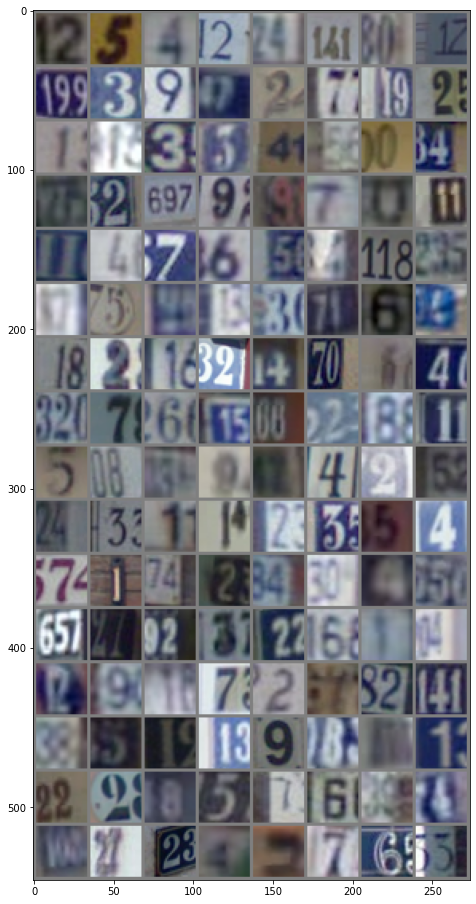

2, 5, 4, 2, 4, 4, 0, 1, 9, 3, 9, 7, 2, 7, 1, 2, 1, 1, 3, 3, 4, 5, 0, 4, 7, 2, 9, 9, 9, 7, 0, 1, 1, 4, 7, 6, 5, 4, 1, 3, 7, 5, 2, 1, 3, 1, 6, 4, 1, 2, 1, 2, 4, 0, 6, 4, 2, 7, 6, 1, 6, 2, 8, 1, 5, 8, 3, 9, 2, 4, 2, 5, 4, 3, 1, 1, 2, 3, 5, 4, 7, 1, 4, 2, 4, 0, 4, 5, 5, 7, 2, 3, 2, 6, 1, 4, 2, 9, 1, 7, 2, 7, 2, 4, 8, 5, 1, 1, 9, 8, 3, 1, 2, 2, 8, 5, 1, 6, 9, 4, 0, 7, 2, 4, 2, 7, 6, 3,


In [44]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
data_iter = iter(train_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{labels[j]}," for j in range(batch_size)))

In [45]:
network = svhnCNN()

optimizer = torch.optim.SGD(params=network.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        network = network.to(device)
        
        optimizer.zero_grad()
        out = network(inputs)  #.forward(inputs)
        loss = loss_function(out, labels)
        loss.backward()
        optimizer.step()
        
        if(i % 1100 == 0):
            print(f"[Epoch:{epoch+1:>3d}:{i:>4d}: loss is {loss:>.9f}]")
print("Finished train")

[Epoch:  1:   0: loss is 2.325857639]
[Epoch:  2:   0: loss is 1.182248950]
[Epoch:  3:   0: loss is 0.490796745]
[Epoch:  4:   0: loss is 0.397886425]
[Epoch:  5:   0: loss is 0.415351301]
[Epoch:  6:   0: loss is 0.409701645]
[Epoch:  7:   0: loss is 0.259648651]
[Epoch:  8:   0: loss is 0.257089019]
[Epoch:  9:   0: loss is 0.263293922]
[Epoch: 10:   0: loss is 0.243655413]
Finished train


In [46]:
total = 0
correct = 0
for _, data in enumerate(test_loader):
    images, labels = data
    
    images, labels = Variable(images), Variable(labels)
    images = images.to(device)
    labels = labels.to(device)
    
    out = network.forward(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print(f"Accuracy is {100*correct/total:.4f}%")

Accuracy is 90.4617%


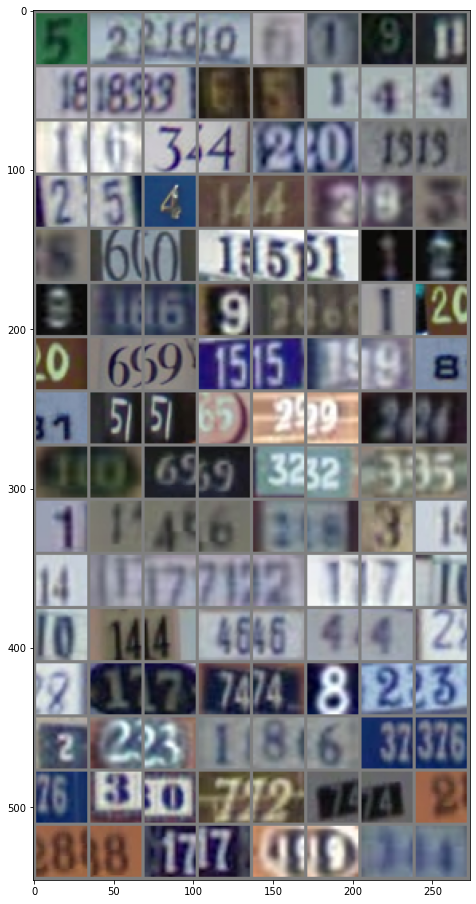

5 2 1 0 6 1 9 1 1 8 3 6 5 1 4 4 1 6 3 4 2 0 1 3 2 5 4 1 4 2 8 3 8 6 0 1 5 1 1 2 9 1 6 9 2 6 1 2 0 6 9 1 5 1 9 8 1 5 1 5 2 9 2 4 1 0 6 9 3 2 3 5 1 1 4 6 2 8 3 1 4 1 7 1 2 1 7 1 0 1 4 4 6 4 4 2 8 1 7 7 4 8 2 3 2 2 3 1 8 6 3 7 6 3 0 7 2 7 4 2 8 8 1 7 1 9 3 4
5 2 1 0 6 1 9 1 1 8 3 6 5 1 4 4 1 6 3 4 2 0 1 9 2 5 4 1 4 2 9 3 6 6 0 1 5 1 1 2 3 1 6 9 2 8 1 2 0 6 9 1 5 1 9 5 4 5 1 9 2 9 2 4 1 0 6 9 3 2 3 5 1 1 4 6 2 6 3 1 4 1 7 1 2 1 7 1 0 1 4 4 6 4 4 2 7 1 7 7 4 8 2 3 2 2 3 1 8 6 3 7 6 3 0 7 2 7 4 2 8 8 1 7 4 9 1 4


In [48]:
data_iter = iter(test_loader)
images, labels = data_iter.next()
#images = images.to(device)
#labels = labels.to(device)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{labels[j]}" for j in range(batch_size)))

images = images.to(device)
outputs = network(images)
_, predicted = torch.max(outputs, 1)
print(' '.join(f'{predicted[j]}' for j in range(batch_size)))